In [1]:
import normalization as nrm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

norm_roi_df = pd.read_csv("BM_AM_180808_190401_norm.csv")
norm_roi_df.head(5)

,Unnamed: 0,image,total cell index,ind cell index,Area,Circ.,AR,Round,Solidity,% depth,...,z norm SCGN_median,z norm Kv2.2_median,z norm DAPI3_median,z norm CAVIII_median,z norm Rec_median,z norm DAPI4_median,z norm Calb_median,z norm PKC_median,z norm Parv_median,z norm DAPI5_median
0,0,21_s1m1,0,0,0.049,0.857,1.450,0.690,0.897,5.259663,...,-0.020591,0.302211,-0.746300,-0.565612,1.181044,-1.485921,-1.086136,-0.721506,-0.334144,-1.151339
1,1,21_s1m1,1,1,0.058,0.878,1.135,0.881,0.892,22.574779,...,2.700736,1.379877,0.631802,-0.585292,0.171825,-1.464316,-1.086136,-0.996451,-0.508083,-0.387308
2,2,21_s1m1,2,2,0.068,0.708,1.663,0.601,0.864,70.322646,...,-0.369889,0.786296,2.512683,-0.948704,-1.030963,-1.198727,-0.961293,-0.966496,-0.540182,1.400713
3,3,21_s1m1,3,3,0.067,0.763,1.336,0.749,0.863,54.642624,...,-0.155288,0.734430,1.223703,-0.391122,1.201069,-1.373327,-0.968633,-0.909795,-0.540182,0.586593
4,4,21_s1m1,4,4,0.099,0.799,1.435,0.697,0.887,17.882495,...,-0.280852,0.550017,0.442898,-0.593164,0.370732,-1.464316,-1.053046,-0.811371,-0.431165,-0.597813


In [26]:
#drop columns you don't want. Overrides roi_cluster_df

roi_cluster_df=norm_roi_df.copy() #creates new df
colNames=roi_cluster_df.columns[roi_cluster_df.columns.str.contains(pat='z norm')] #keeps only znorm data
roi_cluster_df=roi_cluster_df[colNames]
roi_cluster_df=roi_cluster_df.drop(['z norm total cell index', 'z norm ind cell index'], axis=1)

#drops specific channels you don't want
noanalysis = ['DAPI', 'Tarpg3', 'GLT-1', 'Cav3.1', 'Kv2.2', 'Area', 'Circ','AR','Round','Solidity','stddev', 'median']
for col in noanalysis:
    roi_cluster_df=roi_cluster_df.drop(roi_cluster_df.columns[roi_cluster_df.columns.str.contains(pat=col)], axis=1)

#saves data as an array to be used by tsne and umap
roi_cluster_array = roi_cluster_df.iloc[0:7973, 0:11].values

#prints updated df     
roi_cluster_df.shape[0]

7973

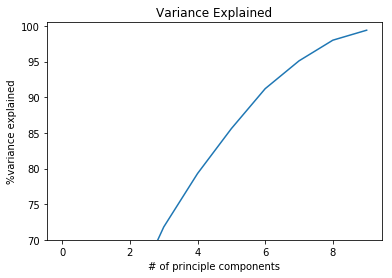

In [23]:
#RUN PCA

#calculate variance explained and cumulative variance explained
covar_matrix=PCA(n_components=10) #number must be equal or less than the # of channels
covar_matrix.fit(roi_cluster_df)
variance=covar_matrix.explained_variance_ratio_
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)

#print graph of the variance explained with [n] features
plt.ylabel('%variance explained')
plt.xlabel('# of principle components')
plt.title('Variance Explained')
plt.ylim(70,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

In [24]:
def ninetyLocator(var):
    for i in range(len(var)):
        if var[i] > 90:
            return i
    return -1

In [25]:
ninetyLocator(var)

6

In [27]:
roi_cluster_array.copy()

array([[-1.60155798, -1.36672519, -0.91889505, ..., -1.12799189,
        -0.83318239, -0.35752697],
       [-0.96179987, -1.56824346, -0.91889505, ..., -1.11083813,
        -1.05936895, -0.52122726],
       [ 0.80238611, -1.31082755, -0.53114244, ..., -1.03434023,
        -1.0866237 , -0.60032093],
       ...,
       [-0.93439362, -0.22678499, -0.80255631, ..., -0.44338496,
        -0.2741992 , -0.13232891],
       [ 1.00089231, -0.30060502,  0.5311899 , ..., -0.18205211,
        -0.42489266, -0.33259914],
       [ 0.042763  ,  1.14025092, -0.22049293, ..., -0.20074926,
         0.50122438, -0.01930503]])

In [29]:
def procedure(roi_cluster_df, condition, outputCSV):
    #use condition
    analysis = []
    if condition == 1:
        comp = 8
        noanalysis = []
    elif condition == 2:
        comp = 8
        noanalysis = ['Islet1']
    elif condition == 3:
        comp = 7
        noanalysis = ['Islet1', 'CD15']
    elif condition == 4:
        comp = 3
        analysis = ['Parv', 'Pax6']
    else:
        raise Exception('condition must be 1 through 4.')

    labelsNOPCA = []
    labelsPCA = []
    
    noanalysis += ['DAPI', 'Tarpg3', 'GLT-1', 'Cav3.1', 'Kv2.2', 'Area', 'Circ','AR','Round','Solidity','stddev', 'median']
    for col in noanalysis:
        roi_cluster_df=roi_cluster_df.drop(roi_cluster_df.columns[roi_cluster_df.columns.str.contains(pat=col)], axis=1)

    if len(analysis) > 0:
        roi_cluster_df = roi_cluster_df[analysis]

    roi_cluster_array = roi_cluster_df.iloc[0:roi_cluster_df.shape[0], 0:roi_cluster_df.shape[1]].values
    roi_cluster_array_noPCA = roi_cluster_array.copy()

    #kmeans and gmm on regular
    kmeans = KMeans(n_clusters=roi_cluster_df.shape[1], random_state = 123) #run on cols
    kmeans.fit(roi_cluster_array_noPCA)

    #roi_clusterResults_df_noPCA=roi_cluster_df.copy()
    #a=kmeans.labels_
    #df_a=pd.DataFrame(a)
    #roi_clusterResults_df_noPCA=pd.concat([roi_clusterResults_df, df_a], axis=1)

    labelsNOPCA = kmeans.labels_

    #run pca
    covar_matrix=PCA(n_components=comp) #its comp right
    covar_matrix.fit(roi_cluster_df)
    variance=covar_matrix.explained_variance_ratio_
    var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
    ncomp = ninetyLocator(var)

    pca_num=PCA(n_components=comp)
    pca_array=pca_num.fit_transform(roi_cluster_df)

    #kmeans and gmm on pca
    kmeans = KMeans(n_clusters=ncomp, random_state = 123) #make sure this is correct. clusters vs comp
    kmeans.fit(pca_array)

    #roi_clusterResults_df=roi_cluster_df.copy()
    #a=kmeans.labels_
    #df_a=pd.DataFrame(a)
    #roi_clusterResults_df=pd.concat([roi_clusterResults_df, df_a], axis=1)

    labelsPCA = kmeans.labels_
    #output

    print('PCA: ', labelsPCA)
    print('No PCA: ', labelsNOPCA)

In [30]:
procedure(roi_cluster_df, 1, 'outputCSV')

PCA:  [3 3 3 ... 3 0 5]
No PCA:  [ 2  2  1 ... 10  1  0]
